In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls gdrive/My\ Drive/

'Colab Notebooks'   Data_n   Resume.pdf   yolo


In [0]:
from google.colab import files
files.upload()

Saving car5.jpeg to car5.jpeg


{'car5.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe1\x00hExif\x00\x00II*\x00\x08\x00\x00\x00\x04\x00\x1a\x01\x05\x00\x01\x00\x00\x00>\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00F\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x03\x00\x00\x001\x01\x02\x00\x11\x00\x00\x00N\x00\x00\x00\x00\x00\x00\x00\xa3\x93\x00\x00\xe8\x03\x00\x00\xa3\x93\x00\x00\xe8\x03\x00\x00Paint.NET v3.5.9\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01/\x02\x0f\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\

In [18]:
!ls

font  gdrive  __pycache__  sample_data	yad2k  yolo_utils.py


In [0]:
!cp gdrive/My\ Drive/yolo/yolo_utils.py yolo_utils.py
!cp -a gdrive/My\ Drive/yolo/yad2k yad2k ## Copying all files ==> -a
!cp -a gdrive/My\ Drive/yolo/font font

In [0]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [0]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores,-1)
    box_class_scores = K.max(box_scores,-1)
    filtering_mask = box_class_scores>threshold
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
 
    return scores, boxes, classes

In [0]:

def iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
 
    return iou

In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

In [0]:
# yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
#                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
#                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
#                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [16]:
# scores, boxes, classes = yolo_eval(yolo_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# with tf.Session() as test_b:
#     print("scores[2] = " + str(scores[2].eval()))
#     print("boxes[2] = " + str(boxes[2].eval()))
#     print("classes[2] = " + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


In [21]:
sess = K.get_session()
class_names = read_classes("gdrive/My Drive/yolo/model_data/coco_classes.txt")
anchors = read_anchors("gdrive/My Drive/yolo/model_data/yolo_anchors.txt")

yolo_model = load_model("gdrive/My Drive/yolo/model_data/yolo.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [24]:
len(class_names)

80

In [0]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [0]:
def predict(sess, image_file):
    image, image_data = preprocess_image( image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    # Generates colors for drawing bounding boxes.
    colors = generate_colors(class_names)

    # Draws bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    # Save the predicted bounding box on the image
    #os.mkdir("out") 
    image.save("out.jpg", quality=90)

    # Display the results in the notebook
    output_image = scipy.misc.imread("out.jpg")

    plt.figure(figsize=(12,12))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 1 boxes for gdrive/My Drive/yolo/car4.jpg
car 0.81 (205, 85) (1074, 633)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


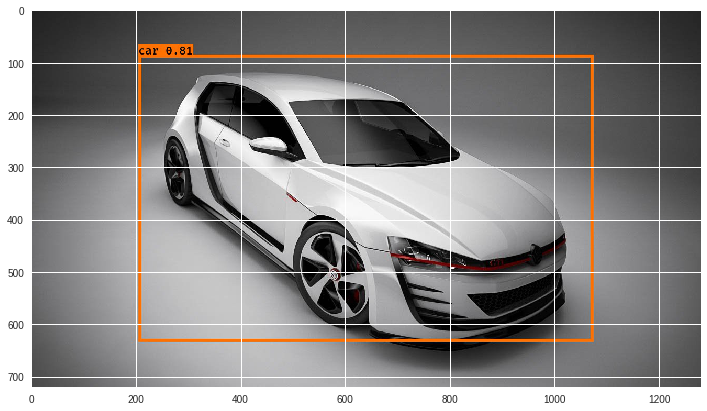

In [31]:
img = plt.imread('gdrive/My Drive/yolo/car4.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/car4.jpg")

Found 10 boxes for gdrive/My Drive/yolo/car3.jpg
car 0.80 (133, 187) (285, 268)
car 0.81 (67, 10) (202, 81)
car 0.83 (427, 185) (550, 253)
car 0.84 (222, 94) (369, 173)
car 0.86 (71, 93) (200, 172)
car 0.86 (292, 184) (431, 261)
car 0.88 (10, 186) (131, 260)
car 0.90 (385, 91) (526, 159)
car 0.90 (384, 12) (522, 80)
car 0.91 (207, 10) (357, 79)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


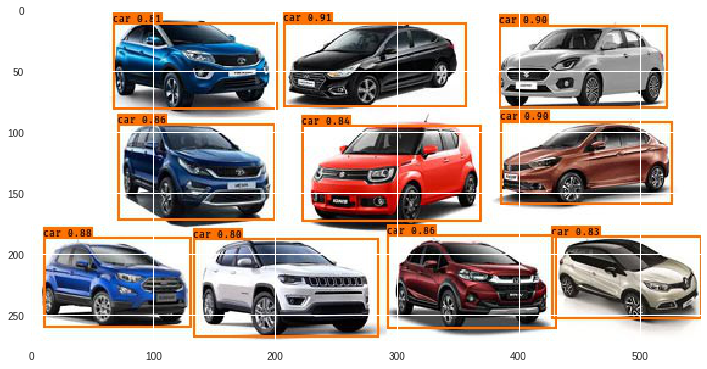

In [32]:
img = plt.imread('gdrive/My Drive/yolo/car3.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/car3.jpg")

Found 2 boxes for gdrive/My Drive/yolo/car1.jpg
car 0.60 (0, 25) (1196, 816)
car 0.68 (10, 139) (321, 603)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


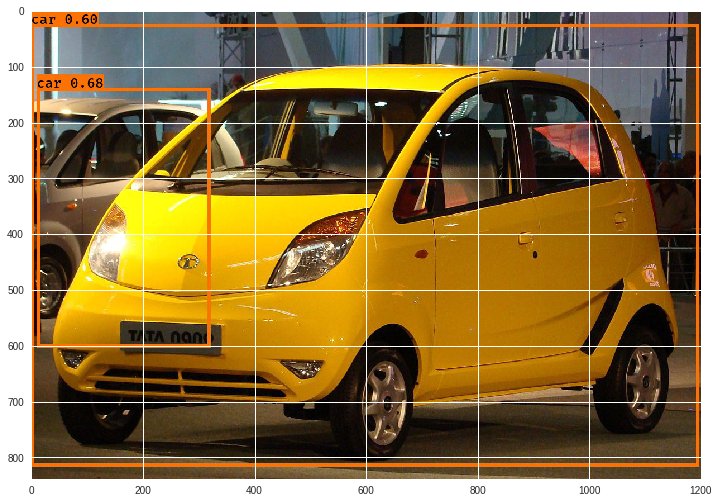

In [34]:
img = plt.imread('gdrive/My Drive/yolo/car1.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/car1.jpg")

Found 3 boxes for gdrive/My Drive/yolo/animals.jpeg
giraffe 0.85 (18, 49) (56, 244)
zebra 0.91 (83, 15) (175, 120)
elephant 0.91 (64, 123) (175, 247)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


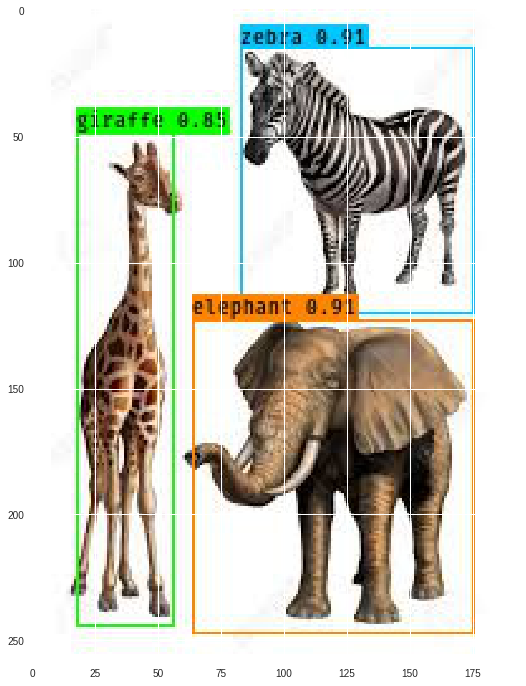

In [37]:
img = plt.imread('gdrive/My Drive/yolo/animals.jpeg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/animals.jpeg")


Found 10 boxes for gdrive/My Drive/yolo/a2.jpg
zebra 0.60 (877, 309) (995, 387)
zebra 0.61 (195, 515) (312, 575)
zebra 0.63 (80, 396) (178, 487)
elephant 0.66 (1045, 160) (1179, 275)
giraffe 0.66 (691, 182) (864, 412)
zebra 0.67 (521, 309) (604, 390)
zebra 0.69 (840, 415) (963, 531)
zebra 0.70 (946, 389) (1100, 508)
zebra 0.70 (1122, 494) (1277, 655)
giraffe 0.74 (192, 172) (375, 462)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


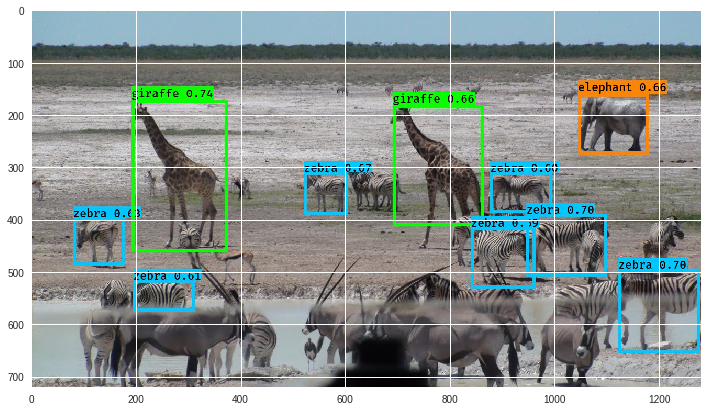

In [39]:
img = plt.imread('gdrive/My Drive/yolo/a2.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/a2.jpg")


Found 3 boxes for gdrive/My Drive/yolo/d1.jpg
mouse 0.74 (464, 297) (521, 320)
keyboard 0.80 (338, 322) (527, 443)
tvmonitor 0.85 (174, 46) (446, 334)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


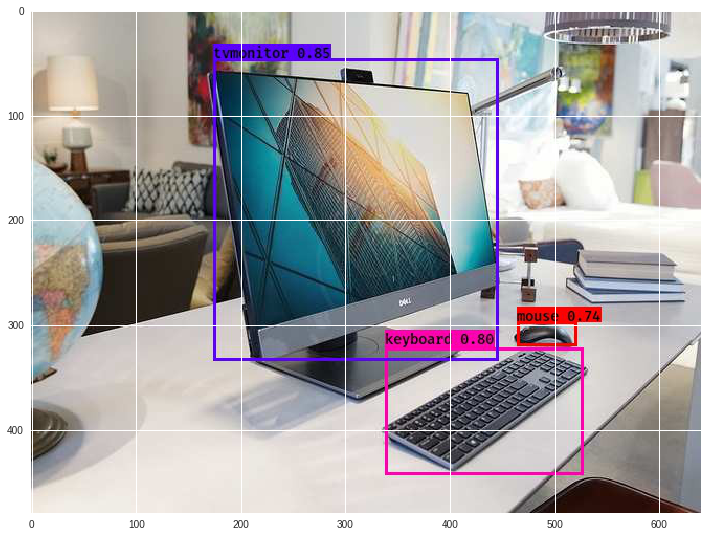

In [46]:
img = plt.imread('gdrive/My Drive/yolo/d1.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/d1.jpg")


Found 5 boxes for gdrive/My Drive/yolo/f1.jpg
apple 0.62 (232, 6) (325, 94)
apple 0.63 (521, 224) (664, 357)
orange 0.79 (11, 126) (94, 211)
apple 0.81 (681, 263) (778, 362)
banana 0.82 (502, 19) (618, 191)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


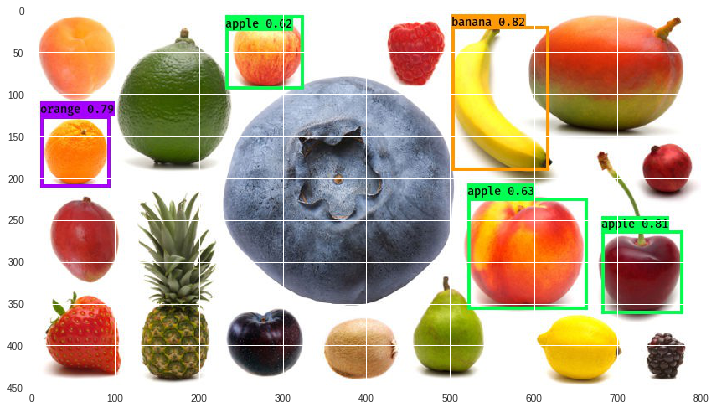

In [43]:
img = plt.imread('gdrive/My Drive/yolo/f1.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/f1.jpg")


Found 10 boxes for gdrive/My Drive/yolo/f2.jpg
apple 0.74 (606, 1967) (1082, 2499)
apple 0.74 (2424, 573) (3002, 1108)
apple 0.76 (2360, 1750) (3157, 2456)
banana 0.77 (32, 734) (1036, 2100)
apple 0.78 (2151, 1114) (2474, 1521)
apple 0.79 (2641, 1088) (3012, 1504)
apple 0.81 (2096, 780) (2501, 1200)
apple 0.81 (169, 1904) (718, 2398)
diningtable 0.81 (174, 458) (3818, 2540)
orange 0.86 (1581, 1452) (2064, 1908)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


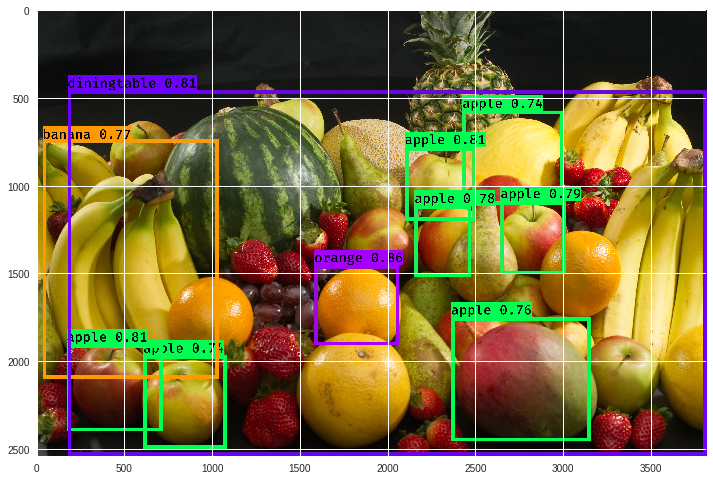

In [42]:
img = plt.imread('gdrive/My Drive/yolo/f2.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/f2.jpg")


Found 5 boxes for gdrive/My Drive/yolo/fruits.jpeg
apple 0.68 (119, 38) (176, 88)
banana 0.70 (161, 73) (262, 151)
orange 0.75 (130, 81) (184, 139)
apple 0.76 (63, 50) (121, 103)
orange 0.83 (74, 84) (138, 139)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


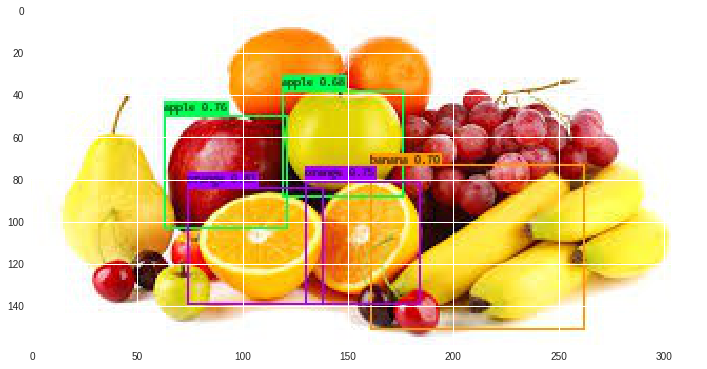

In [40]:
img = plt.imread('gdrive/My Drive/yolo/fruits.jpeg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

out_scores, out_boxes, out_classes = predict(sess, "gdrive/My Drive/yolo/fruits.jpeg")
